In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn stuff
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# regressor models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# model functionality and validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
# data pipeline

# read in file
raw_data = pd.read_csv("AmesHousing.csv", "~")

# see what has been loaded
raw_data.keys()

# select most likely key features
data = raw_data[["SalePrice", "1st Flr SF", "2nd Flr SF", "MS Zoning", "Lot Frontage", "Lot Area", "Land Contour", "Bldg Type", "House Style", "Overall Qual", "Overall Cond", "Year Built", "Year Remod/Add", "Bsmt Qual", "Bsmt Cond", "Heating", "Central Air", "Full Bath", "Half Bath", "Bedroom AbvGr", "Fireplaces", "Garage Type", "Garage Cars", "Pool Area", "Pool QC", "Yr Sold"]]

# ensure we've loaded what we want
data.keys()

# convert to a simplified dataframe for initial work
simple_data = data[["SalePrice", "1st Flr SF", "2nd Flr SF", "Year Built", "Full Bath", "Half Bath", "Bedroom AbvGr", "Garage Cars", "Yr Sold"]]

# fill in nan for 2nd floor square feet with zeros, which makes sense
simple_data.loc[:, "2nd Flr SF"].fillna(0, inplace=True)

# calculate simple square footage
square_feet = simple_data.loc[:,"1st Flr SF"] + simple_data.loc[:,"2nd Flr SF"]

# add this to the data frame then clean up the data frame some
simple_data = pd.concat((simple_data, square_feet), axis=1)
simple_data.drop(0, axis=1, inplace=True)
simple_data.drop("1st Flr SF", axis=1, inplace=True)
simple_data.drop("2nd Flr SF", axis=1, inplace=True)

# fix nans
simple_data["Garage Cars"].fillna(0, inplace=True)

# get Y labels
Y = simple_data.loc[:,"SalePrice"]

simple_data.pop("SalePrice")
print simple_data.describe()

        Year Built    Full Bath    Half Bath  Bedroom AbvGr  Garage Cars  \
count  2930.000000  2930.000000  2930.000000    2930.000000  2930.000000   
mean   1971.356314     1.566553     0.379522       2.854266     1.766212   
std      30.245361     0.552941     0.502629       0.827731     0.761137   
min    1872.000000     0.000000     0.000000       0.000000     0.000000   
25%    1954.000000     1.000000     0.000000       2.000000     1.000000   
50%    1973.000000     2.000000     0.000000       3.000000     2.000000   
75%    2001.000000     2.000000     1.000000       3.000000     2.000000   
max    2010.000000     4.000000     2.000000       8.000000     5.000000   

           Yr Sold  
count  2930.000000  
mean   2007.790444  
std       1.316613  
min    2006.000000  
25%    2007.000000  
50%    2008.000000  
75%    2009.000000  
max    2010.000000  


/home/brian/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [3]:
def run_model(model, name, x_train, x_test, y_train, y_test):
    '''
    Run a fit on the provided data using the provided model
    
    print out the RSME as the result
    '''
    model.fit(x_train, y_train)
    
    #print model.__class__.__name__
    
    y_preds = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_preds, y_test))
    
#     scores = cross_val_score(model, simple_data, Y, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)
#     scores *= -1
#     rmse = np.sqrt(scores).mean()
    
    print "{:40} {:7.1f}".format(name + " RMSE:", rmse)
    
    return y_preds
    
    
def run_log_model(model, name, x_train, x_test, y_train, y_test):
    '''
    Run a fit on the provided data using the provided model
    
    print out the RSME as the result
    '''
    log_y_train = np.log(y_train)
    model.fit(x_train, log_y_train)
    
    log_y_preds = model.predict(x_test)
    y_preds = np.exp(log_y_preds)
    rmse = np.sqrt(mean_squared_error(y_preds, y_test))
    
    print "{:40} {:7.1f}".format(name + " RMSE:", rmse)
    
    return y_preds
    
def plot_error(axis, name, y_test, y_preds, color="blue", label=None):
    '''
    plot the error relative to the price of the house
    '''    
    axis.scatter(y_test, y_preds - y_test, alpha=0.3, color=color, s=100, label=label)
    axis.set_title("Error rate for " + name)
    axis.set_xlabel("Actual Price of House")
    axis.set_ylabel("Predicted Price Error")
    axis.legend()

In [4]:
def my_linear(x):
    '''
    does a crap estimation of the error manually
    '''
    return 150000.0 - x

res min -595003.461246
res max 125066.168641
[[ 1505.0350236]]
[-240606.55844653]


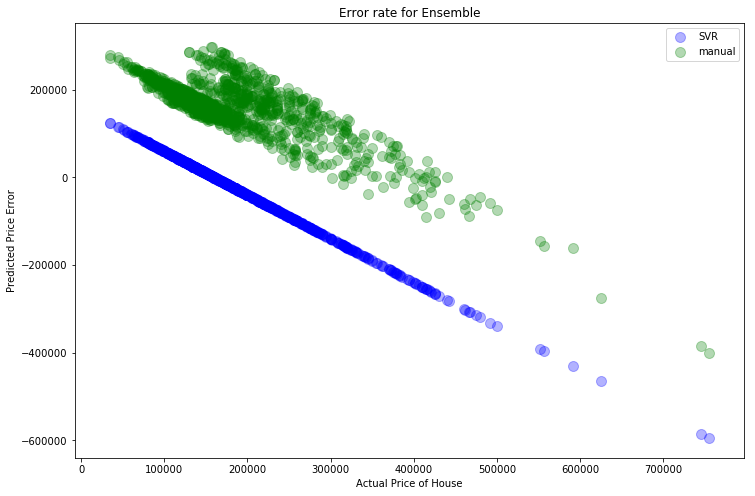

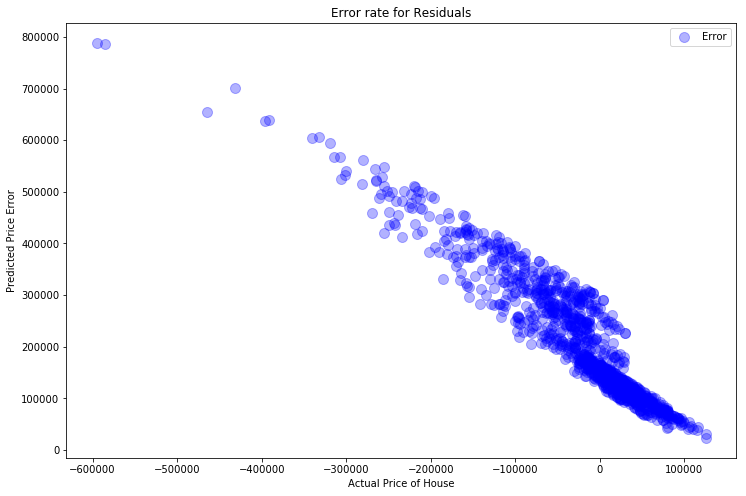

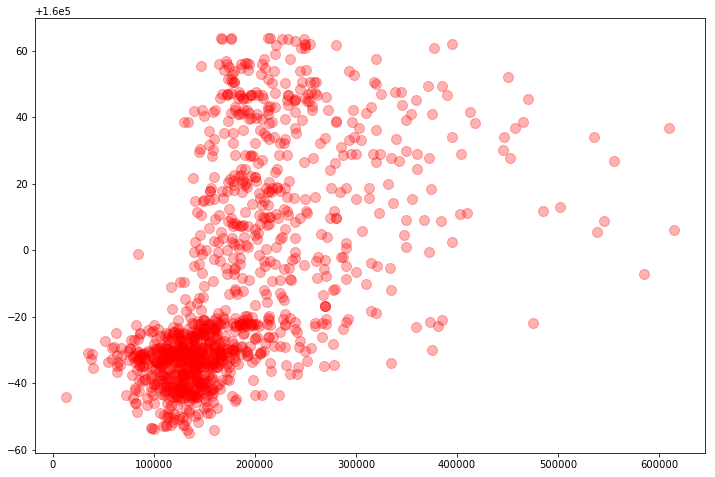

In [7]:
# support vector error on non-log price looks incredibly linear  
# lets try to make a linear regression on the errors and use that
# to compensate for the SVR predictions

# figure out new splits because need different sets of data for each stage
# hold back 20% for validation
x_train, x_eval, y_train, y_eval = train_test_split(simple_data.values, Y, random_state=1337, test_size=0.20)

# split the actual train set into 2 equal sections in order to train both stages
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, random_state=32, test_size=0.5)

# convert to 1d matrix instead of array because SKlearn goes nuts
y_train1 = np.array(y_train1).reshape(-1, 1)
y_train2 = np.array(y_train2).reshape(-1, 1)

# make an support vector machine regressor
stage1_model = SVR()

# fit the model on the training data
stage1_model.fit(x_train1, y_train1)

# print y_train1.shape
# print y_train2.shape

s1_results = np.array(stage1_model.predict(x_train1)).reshape(-1,1)

# figure out the errors (only useful for plotting)
# residuals = np.array(stage1_model.predict(x_train2) - y_train2).reshape(-1, 1)
residuals = np.array(stage1_model.predict(x_train2)).reshape(-1, 1) - y_train2

# print "res shape:", residuals.shape
residuals = np.array(residuals).reshape(-1, 1)
# print "new res shape:", residuals.shape


print "res min", residuals.min()
print "res max", residuals.max()

# make the stage 2 linear model
stage2_model = LinearRegression(fit_intercept=True)

# get stage 1 predictions on 2nd set of data
s1_pred = np.array(stage1_model.predict(x_train2)).reshape(-1,1)

# print s1_pred.shape
manual_s2_pred = my_linear(s1_pred)

manual_preds = s1_pred - manual_s2_pred

# fit stage two on the errors of stage one relative to the actual prices
stage2_model.fit(s1_pred, y_train2)

s2_results = np.array(stage2_model.predict(s1_pred)).reshape(-1, 1)

combined = s1_pred + s2_results

print stage2_model.coef_
print stage2_model.intercept_ / 1000

fig, bx = plt.subplots(figsize=(12, 8))
plot_error(bx, "Ensemble", y_train2, s1_pred, label="SVR")
plot_error(bx, "Ensemble", y_train2, combined, color="green", label="manual")
# plot_error(bx, "Ensemble", Y_t, s2_error, color="red")
# plot_error(bx, "Ensemble", Y_t, residuals - s2_error, color="purple")

# print
# print residuals.shape
# print s2_results.shape

model_2 = np.arange(-600000, 130000, len(residuals)).reshape(-1, 1)
model_2_preds = stage2_model.predict(model_2)

# try to plot residual differences from stage 2
fig, cx = plt.subplots(figsize=(12, 8))
plot_error(cx, "Residuals", residuals, s2_results, label="Error")
# plot_error(cx, "Residuals", model_2, model_2_preds, color="red", label="linear regression")

fig, dx = plt.subplots(figsize=(12,8))
dx.scatter(y_train1, s1_results, color="red", alpha=0.3, s=100)

In [ ]:
# support vector error on non-log price looks incredibly linear  
# lets try to make a linear regression on the errors and use that
# to compensate for the SVR predictions

# figure out new splits because need different sets of data for each stage
# hold back 20% for validation
x_train, x_eval, y_train, y_eval = train_test_split(simple_data.values, Y, random_state=1337, test_size=0.20)

# split the actual train set into 2 equal sections in order to train both stages
x_train1, x_train2, y_train1, y_train2 = train_test_split(x_train, y_train, random_state=32, test_size=0.5)

# convert to 1d matrix instead of array because SKlearn goes nuts
y_train1 = np.array(y_train1).reshape(-1, 1)
y_train2 = np.array(y_train2).reshape(-1, 1)

# make an support vector machine regressor
stage1_model = SVR()

# fit the model on the training data
stage1_model.fit(x_train1, y_train1)



# print y_train1.shape
# print y_train2.shape

s1_results = np.array(stage1_model.predict(x_train1)).reshape(-1,1)

# figure out the errors (only useful for plotting)
# residuals = np.array(stage1_model.predict(x_train2) - y_train2).reshape(-1, 1)
residuals = np.array(stage1_model.predict(x_train2)).reshape(-1, 1) - y_train2

# print "res shape:", residuals.shape
residuals = np.array(residuals).reshape(-1, 1)
# print "new res shape:", residuals.shape


print "res min", residuals.min()
print "res max", residuals.max()

# make the stage 2 linear model
stage2_model = LinearRegression(fit_intercept=True)

# get stage 1 predictions on 2nd set of data
s1_pred = np.array(stage1_model.predict(x_train2)).reshape(-1,1)

# print s1_pred.shape
manual_s2_pred = my_linear(s1_pred)

manual_preds = s1_pred - manual_s2_pred

# fit stage two on the errors of stage one relative to the actual prices
stage2_model.fit(s1_pred, y_train2)

s2_results = np.array(stage2_model.predict(s1_pred)).reshape(-1, 1)

combined = s1_pred + s2_results

print stage2_model.coef_
print stage2_model.intercept_ / 1000

fig, bx = plt.subplots(figsize=(12, 8))
plot_error(bx, "Ensemble", y_train2, s1_pred, label="SVR")
plot_error(bx, "Ensemble", y_train2, combined, color="green", label="manual")
# plot_error(bx, "Ensemble", Y_t, s2_error, color="red")
# plot_error(bx, "Ensemble", Y_t, residuals - s2_error, color="purple")

# print
# print residuals.shape
# print s2_results.shape

model_2 = np.arange(-600000, 130000, len(residuals)).reshape(-1, 1)
model_2_preds = stage2_model.predict(model_2)

# try to plot residual differences from stage 2
fig, cx = plt.subplots(figsize=(12, 8))
plot_error(cx, "Residuals", residuals, s2_results, label="Error")
# plot_error(cx, "Residuals", model_2, model_2_preds, color="red", label="linear regression")

fig, dx = plt.subplots(figsize=(12,8))
dx.scatter(y_train1, s1_results, color="red", alpha=0.3, s=100)